In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [11]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 
CHANNELS = 3
EPOCHS = 15

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 1273 files belonging to 2 classes.


In [13]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [14]:
len(dataset)

40

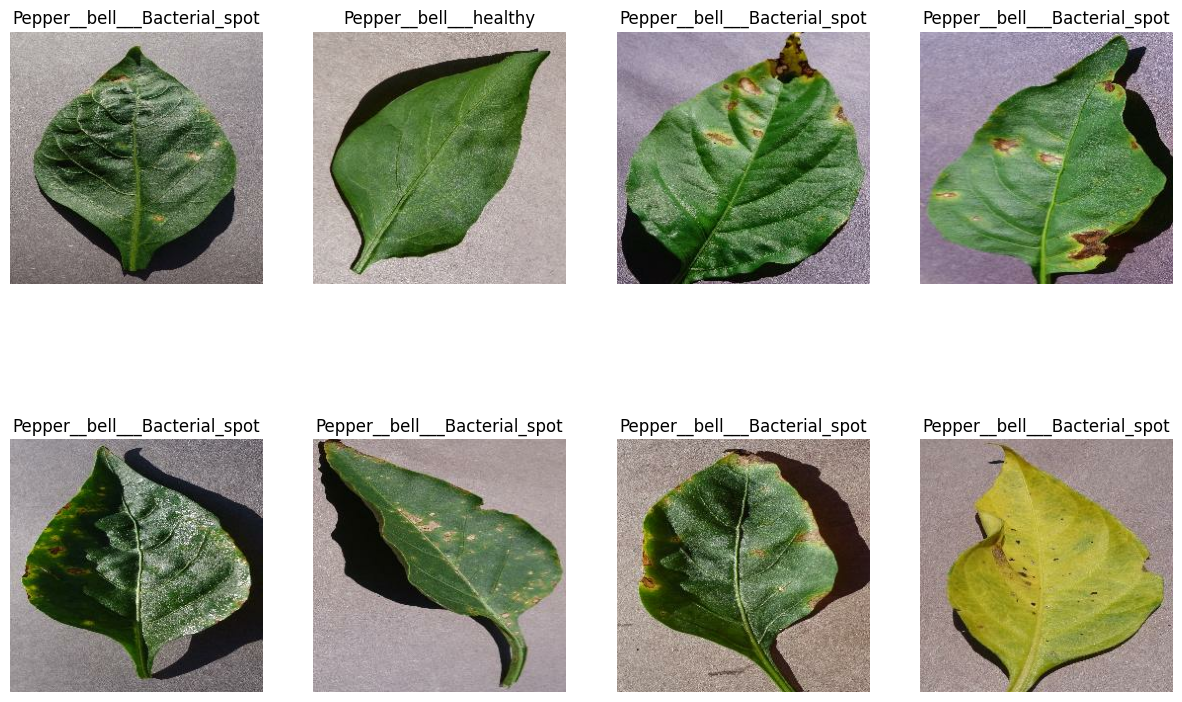

In [15]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [16]:
train_size = 0.8
len(dataset)*train_size

32.0

In [17]:
train_ds = dataset.take(32)
len(train_ds)

32

In [18]:
test_ds = dataset.skip(32)
len(test_ds)

8

In [19]:
val_size=0.1
len(dataset)*val_size

4.0

In [20]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [21]:
test_ds = test_ds.skip(4)
len(test_ds)

4

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15


32/32 [==============================] - 21s 584ms/step - loss: 0.4914 - accuracy: 0.7581 - val_loss: 0.4242 - val_accuracy: 0.7812
Epoch 2/15
32/32 [==============================] - 18s 542ms/step - loss: 0.2626 - accuracy: 0.8781 - val_loss: 0.1975 - val_accuracy: 0.9375
Epoch 3/15
32/32 [==============================] - 18s 562ms/step - loss: 0.1993 - accuracy: 0.9341 - val_loss: 0.1261 - val_accuracy: 0.9531
Epoch 4/15
32/32 [==============================] - 18s 567ms/step - loss: 0.1243 - accuracy: 0.9479 - val_loss: 0.1666 - val_accuracy: 0.9219
Epoch 5/15
32/32 [==============================] - 19s 582ms/step - loss: 0.1265 - accuracy: 0.9538 - val_loss: 0.0991 - val_accuracy: 0.9766
Epoch 6/15
32/32 [==============================] - 19s 576ms/step - loss: 0.0524 - accuracy: 0.9843 - val_loss: 0.1287 - val_accuracy: 0.9688
Epoch 7/15
32/32 [==============================] - 19s 574ms/step - loss: 0.0476 - accuracy: 0.9882 - val_loss: 0.0744 - val_accuracy: 0.99

In [32]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 1s 161ms/step - loss: 0.0354 - accuracy: 0.9922


In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

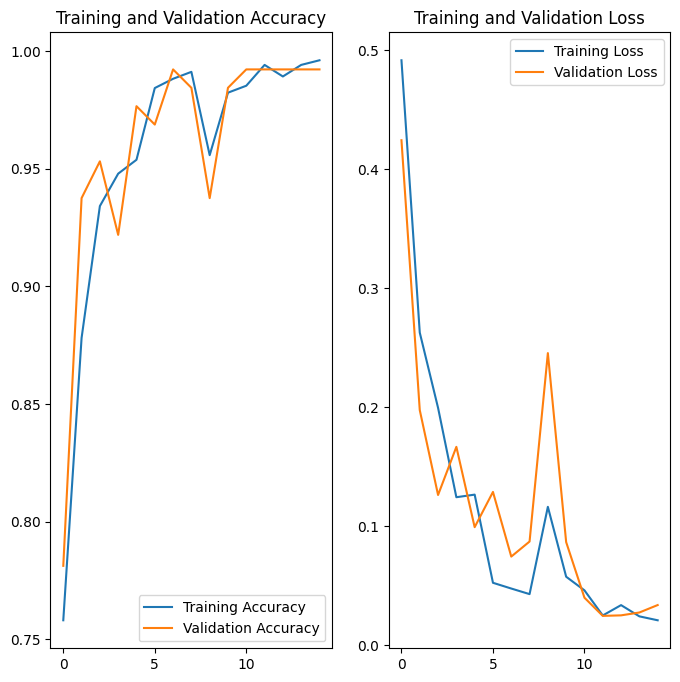

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___Bacterial_spot
1/1 [==============================] - 0s 316ms/step
predicted label: Pepper__bell___Bacterial_spot


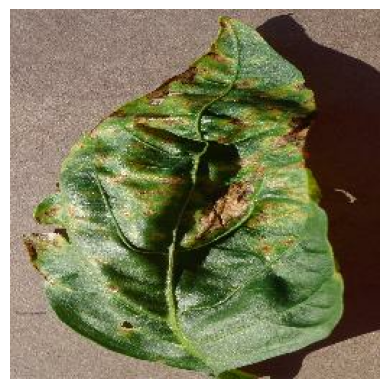

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.axis("off")
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


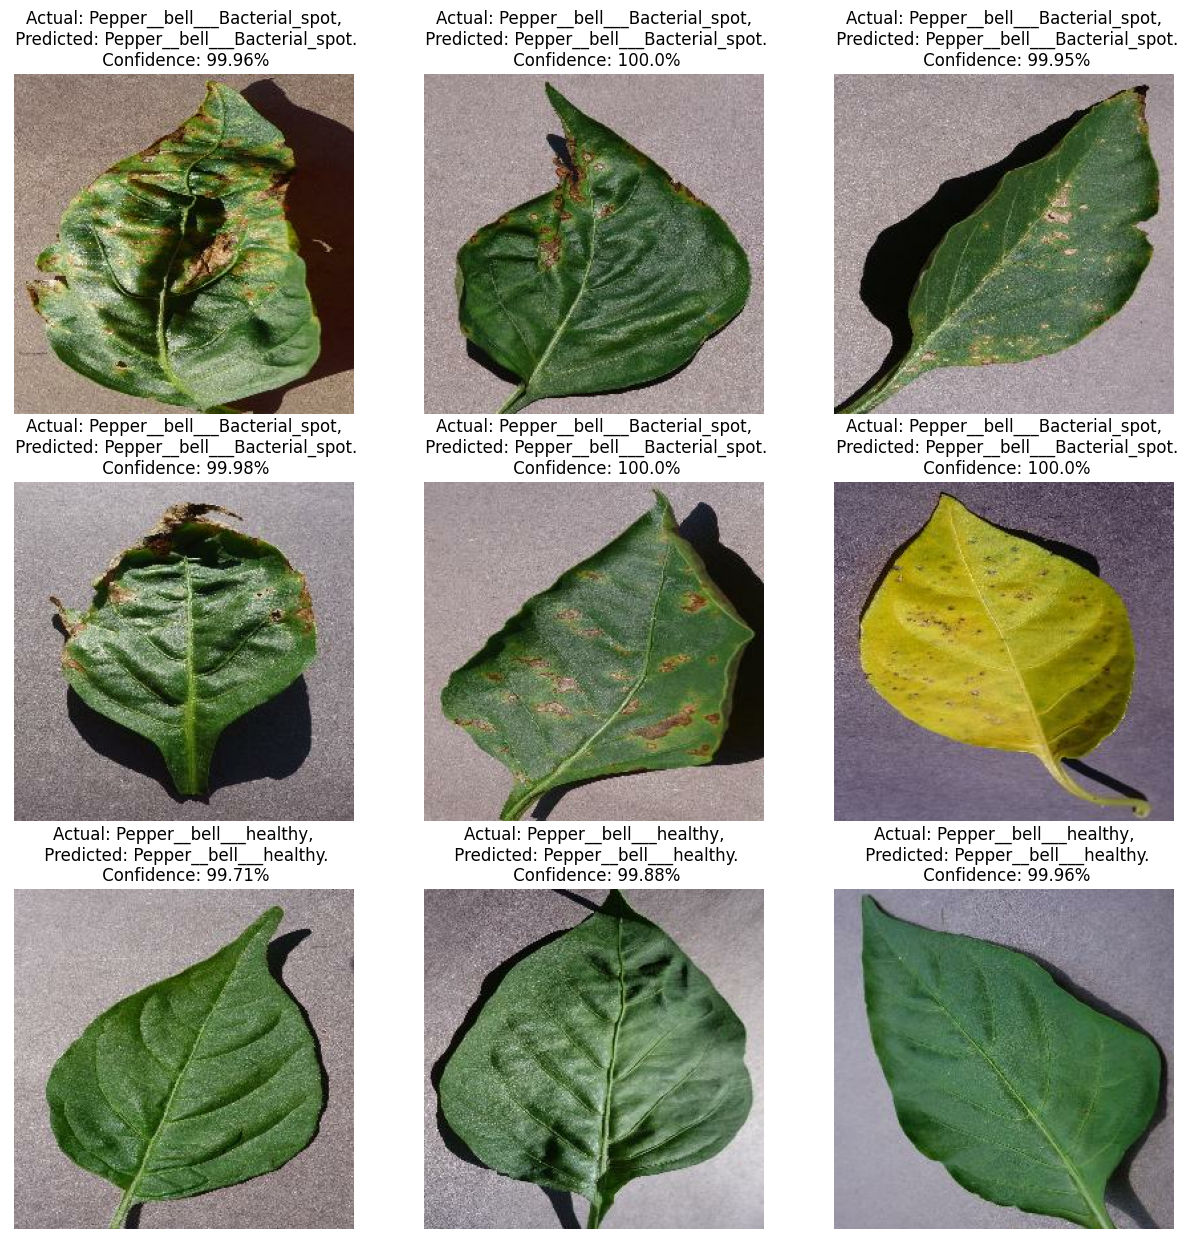

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [39]:
model.save("./pepper.h5")

c:\Users\suyash joshi\anaconda3\envs\pepper\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import os
from PIL import Image  # Import Pillow for image processing
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def load_and_preprocess_images(image_paths):
  """
  Loads images from given paths, resizes, and normalizes them.

  Args:
      image_paths (list): A list of image file paths.

  Returns:
      numpy.ndarray: A NumPy array containing the preprocessed image data.
  """

  # Define image size (adjust as needed)
  img_size = (256, 256)

  # Load and preprocess images
  images = []
  for image_path in image_paths:
    try:
      img = Image.open(image_path)  # Read image using Pillow's Image.open
      img = img.convert('L')  # Convert to grayscale (if color channels are present)
      img = img.resize(img_size)    # Resize image using Pillow's resize
      img = np.array(img) / 255.0  # Convert to NumPy array and normalize
      img = img.flatten()  # Flatten the image data
      images.append(img)
    except (OSError, FileNotFoundError) as e:
      print(f"Error loading image: {image_path}. Skipping...")
      pass  # Skip images that fail to load

  # Convert to NumPy array
  images_np = np.array(images)
  return images_np

# Define dataset paths (replace with your actual paths)
dataset_path = "C:\\Users\\suyash joshi\\OneDrive\\Desktop\\Python Projects\\Bell Pepper disease classifier\\PlantVillage"
healthy_dir = os.path.join(dataset_path, "Pepper__bell___healthy")
bacterial_dir = os.path.join(dataset_path, "Pepper__bell___Bacterial_spot")

# Load image paths and labels
healthy_image_paths = [os.path.join(healthy_dir, filename) for filename in os.listdir(healthy_dir)]
bacterial_image_paths = [os.path.join(bacterial_dir, filename) for filename in os.listdir(bacterial_dir)]

# Load and preprocess images (class labels: 0 - healthy, 1 - bacterial)
X_healthy = load_and_preprocess_images(healthy_image_paths)
X_bacterial = load_and_preprocess_images(bacterial_image_paths)
X = np.concatenate((X_healthy, X_bacterial))
y = np.array([0] * len(healthy_image_paths) + [1] * len(bacterial_image_paths))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report (optional)
print(classification_report(y_test, y_pred))


Accuracy: 0.8549019607843137
              precision    recall  f1-score   support

           0       0.92      0.39      0.54        57
           1       0.85      0.99      0.91       198

    accuracy                           0.85       255
   macro avg       0.88      0.69      0.73       255
weighted avg       0.86      0.85      0.83       255



In [16]:
import os
from PIL import Image  # Import Pillow for image processing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def load_and_preprocess_images(image_paths):
  """
  Loads images from given paths, resizes, and normalizes them.

  Args:
      image_paths (list): A list of image file paths.

  Returns:
      numpy.ndarray: A NumPy array containing the preprocessed image data.
  """

  # Define image size (adjust as needed)
  img_size = (224, 224)

  # Load and preprocess images
  images = []
  for image_path in image_paths:
    try:
      img = Image.open(image_path)  # Read image using Pillow's Image.open
      img = img.resize(img_size)    # Resize image using Pillow's resize
      img = np.array(img) / 255.0   # Convert to NumPy array and normalize
      images.append(img.flatten())  # Flatten the image data
    except (OSError, FileNotFoundError) as e:
      print(f"Error loading image: {image_path}. Skipping...")
      pass  # Skip images that fail to load

  # Convert to NumPy array
  images_np = np.array(images)
  return images_np

# Define dataset paths (replace with your actual paths)
dataset_path = "C:\\Users\\suyash joshi\\OneDrive\\Desktop\\Python Projects\\Bell Pepper disease classifier\\PlantVillage"
healthy_dir = os.path.join(dataset_path, "Pepper__bell___healthy")
bacterial_dir = os.path.join(dataset_path, "Pepper__bell___Bacterial_spot")

# Load image paths and labels
healthy_image_paths = [os.path.join(healthy_dir, filename) for filename in os.listdir(healthy_dir)]
bacterial_image_paths = [os.path.join(bacterial_dir, filename) for filename in os.listdir(bacterial_dir)]

# Load and preprocess images (class labels: 0 - healthy, 1 - bacterial)
X = load_and_preprocess_images(healthy_image_paths + bacterial_image_paths)
y = np.array([0] * len(healthy_image_paths) + [1] * len(bacterial_image_paths))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed

# Train the model
knn.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report (optional)
print(classification_report(y_test, y_pred))


Accuracy: 0.6705882352941176
              precision    recall  f1-score   support

           0       0.39      0.84      0.53        57
           1       0.93      0.62      0.75       198

    accuracy                           0.67       255
   macro avg       0.66      0.73      0.64       255
weighted avg       0.81      0.67      0.70       255



In [19]:
import os
from PIL import Image  # Import Pillow for image processing
import numpy as np
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def load_and_preprocess_images(image_paths, label):
  """
  Loads images from given paths, resizes, and normalizes them.

  Args:
      image_paths (list): A list of image file paths.
      label (int): The class label for all images in this list (0 - healthy, 1 - bacterial).

  Returns:
      numpy.ndarray: A NumPy array containing the preprocessed image data.
      list: A list containing the labels for each image.
  """

  # Define image size (adjust as needed)
  img_size = (256, 256)

  images = []
  labels = []
  for image_path in image_paths:
    try:
      img = Image.open(image_path)  # Read image using Pillow's Image.open
      img = img.convert('L')  # Convert to grayscale
      img = img.resize(img_size)  # Resize image
      img = np.array(img) / 255.0  # Convert to NumPy array and normalize
      images.append(img.flatten())  # Flatten the image data
      labels.append(label)
    except (OSError, FileNotFoundError) as e:
      print(f"Error loading image: {image_path}. Skipping...")
      pass

  return np.array(images), labels

# Define dataset paths (replace with your actual paths)
dataset_path = "C:\\Users\\suyash joshi\\OneDrive\\Desktop\\Python Projects\\Bell Pepper disease classifier\\PlantVillage"
healthy_dir = os.path.join(dataset_path, "Pepper__bell___healthy")
bacterial_dir = os.path.join(dataset_path, "Pepper__bell___Bacterial_spot")

# Load image paths and labels
healthy_image_paths = [os.path.join(healthy_dir, filename) for filename in os.listdir(healthy_dir)]
bacterial_image_paths = [os.path.join(bacterial_dir, filename) for filename in os.listdir(bacterial_dir)]

# Load and preprocess images (class labels: 0 - healthy, 1 - bacterial)
X_healthy, y_healthy = load_and_preprocess_images(healthy_image_paths, 0)
X_bacterial, y_bacterial = load_and_preprocess_images(bacterial_image_paths, 1)

# Combine data from both classes
X = np.concatenate((X_healthy, X_bacterial))
y = np.concatenate((y_healthy, y_bacterial))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SVM classifier
clf = SVC(kernel='linear')  # Choose a suitable kernel (linear for efficiency)

# Train the model
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report (optional)
print(classification_report(y_test, y_pred))


Accuracy: 0.796078431372549
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        57
           1       0.88      0.86      0.87       198

    accuracy                           0.80       255
   macro avg       0.71      0.72      0.71       255
weighted avg       0.80      0.80      0.80       255

